In [ ]:
#!pip install pandas_datareader
#!pip install yfinance --upgrade --no-cache-dir
#!pip install quandl
#!pip install plotly
#!pip install cufflinks
#!pip install tensorflow
#!pip install numpy --upgrade

In [22]:
import os
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
# Not used right now
#from torch.autograd import Variable

In [46]:
 def importRawData():
    localData = pd.DataFrame()
    for filename in os.listdir(os.getcwd()):
        if filename.endswith(".csv"):
            tempdf = pd.read_csv(filename)
            tempdf['date'] = pd.to_datetime(tempdf['date'], unit='s')
            #Rename Columns to allow for appending other data
            cols = list(tempdf)
            cols.insert(0,cols.pop(cols.index('close')))
            tempdf = tempdf.loc[:,cols]
            tempdf = tempdf.rename(
                columns = {
                    column_name: filename[0:6] + '_' + column_name for index,column_name in enumerate(tempdf.columns)
                }
            )
                
            if localData.empty == True:
                localData = tempdf
            else:
                if len(localData.columns) == len(tempdf.columns):
                    localData = localData.append(tempdf)
                else:
                    raise Exception("Column counts of csv do not match")
            
        else:
            continue
    localData = localData.set_index('BTCUSD_date')
    
    return localData

In [57]:
## Add Moving averages
def addFeaturesToDF(df=pd.DataFrame()):
    localData = df.copy()
    
    
    for colname in localData.columns:
        if colname.endswith("close"):
            
            localData[colname[0:6] +'-10MA'] = localData[colname].rolling(10).mean()
            localData[colname[0:6] +'-20MA'] = localData[colname].rolling(20).mean()
            localData[colname[0:6] +'-50MA'] = localData[colname].rolling(50).mean()
            localData[colname[0:6] +'-100MA'] = localData[colname].rolling(100).mean()
            localData[colname[0:6] +'-200MA'] = localData[colname].rolling(200).mean()
            ##localCopy[colname[0:6] +'-DPercentChange'] = ((histData[colname]-histData['Open'])/histData['Open'])*100.0
            localData[colname[0:6] +'-Close-1'] = localData[colname].shift(1)
            localData[colname[0:6] +'-Close-2'] = localData[colname].shift(2)
            localData[colname[0:6] +'-Close-3'] = localData[colname].shift(3)
            localData[colname[0:6] +'-Close-4'] = localData[colname].shift(4)
            localData[colname[0:6] +'-Close-5'] = localData[colname].shift(5)
            
    localData = localData.dropna()
    return localData



In [110]:
rawdata = importRawData()
formatteddata = addFeaturesToDF(rawdata)

In [111]:
rawdata.head

<bound method NDFrame.head of                      BTCUSD_close  BTCUSD_low  BTCUSD_high  BTCUSD_open  \
BTCUSD_date                                                               
2020-01-01 00:00:00       7186.68     7195.24      7196.25      7183.14   
2020-01-01 00:01:00       7184.03     7187.67      7188.06      7182.20   
2020-01-01 00:02:00       7182.43     7184.41      7184.71      7180.26   
2020-01-01 00:03:00       7185.94     7183.83      7188.94      7182.49   
2020-01-01 00:04:00       7179.78     7185.54      7185.54      7178.64   
...                           ...         ...          ...          ...   
2021-05-12 00:25:00      56936.72    56877.58     56952.58     56836.73   
2021-05-12 00:26:00      56985.32    56936.73     57005.57     56936.72   
2021-05-12 00:27:00      56995.56    56985.33     57009.97     56950.00   
2021-05-12 00:28:00      56980.00    56995.56     57007.94     56966.09   
2021-05-12 00:29:00      56985.68    56980.00     56998.00     56930.4

In [112]:
formatteddata.head


<bound method NDFrame.head of                      BTCUSD_close  BTCUSD_low  BTCUSD_high  BTCUSD_open  \
BTCUSD_date                                                               
2020-01-01 03:19:00       7235.50     7234.93      7235.50      7230.00   
2020-01-01 03:20:00       7234.65     7234.11      7236.89      7232.87   
2020-01-01 03:21:00       7233.48     7235.71      7236.74      7233.07   
2020-01-01 03:22:00       7236.18     7235.32      7236.47      7234.44   
2020-01-01 03:23:00       7234.89     7235.09      7237.14      7234.77   
...                           ...         ...          ...          ...   
2021-05-12 00:25:00      56936.72    56877.58     56952.58     56836.73   
2021-05-12 00:26:00      56985.32    56936.73     57005.57     56936.72   
2021-05-12 00:27:00      56995.56    56985.33     57009.97     56950.00   
2021-05-12 00:28:00      56980.00    56995.56     57007.94     56966.09   
2021-05-12 00:29:00      56985.68    56980.00     56998.00     56930.4

In [113]:
#formatteddata.plot()
#pyplot.show()

<h1>Keras Setup</h1>

In [114]:
list(formatteddata)

['BTCUSD_close',
 'BTCUSD_low',
 'BTCUSD_high',
 'BTCUSD_open',
 'BTCUSD_volume',
 'BTCUSD-10MA',
 'BTCUSD-20MA',
 'BTCUSD-50MA',
 'BTCUSD-100MA',
 'BTCUSD-200MA',
 'BTCUSD-Close-1',
 'BTCUSD-Close-2',
 'BTCUSD-Close-3',
 'BTCUSD-Close-4',
 'BTCUSD-Close-5']

In [115]:
train_dates = pd.to_datetime(formatteddata.index)
cols = list(formatteddata)
dftraining = formatteddata[cols].astype(float)


In [116]:
scaler = StandardScaler()
scaler = scaler.fit(dftraining)
dftrainingscaled = scaler.transform(dftraining)

In [117]:
trainX = []
trainY = []

n_future = 1 # Number of periods we want to predict into the future
n_past = 14 # Number of past periods to use for predicting future

for i in range(n_past, len(dftrainingscaled) - n_future +1):
    trainX.append(dftrainingscaled[i - n_past:i, 0:dftraining.shape[1]])
    trainY.append(dftrainingscaled[i + n_future -1: i + n_future,0])
    
trainX, trainY = np.array(trainX), np.array(trainY)



In [118]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (713658, 14, 15).
trainY shape == (713658, 1).


In [119]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 14, 64)            20480     
_________________________________________________________________
lstm_15 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 32,929
Trainable params: 32,929
Non-trainable params: 0
_________________________________________________________________


In [120]:
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/10
20072/20072 [==============================] - 233s 11ms/step - loss: 0.0138 - val_loss: 2.4149e-04
Epoch 2/10
20072/20072 [==============================] - 218s 11ms/step - loss: 0.0102 - val_loss: 0.0311
Epoch 3/10
20072/20072 [==============================] - 217s 11ms/step - loss: 0.0100 - val_loss: 1.8153e-04
Epoch 4/10
20072/20072 [==============================] - 223s 11ms/step - loss: 0.0098 - val_loss: 5.2571e-05
Epoch 5/10
20072/20072 [==============================] - 213s 11ms/step - loss: 0.0097 - val_loss: 1.5712e-04
Epoch 6/10
20072/20072 [==============================] - 212s 11ms/step - loss: 0.0098 - val_loss: 4.7051e-04
Epoch 7/10
20072/20072 [==============================] - 211s 11ms/step - loss: 0.0097 - val_loss: 0.0048
Epoch 8/10
20072/20072 [==============================] - 211s 11ms/step - loss: 0.0097 - val_loss: 0.0066
Epoch 9/10
20072/20072 [==============================] - 211s 10ms/step - loss: 0.0097 - val_loss: 0.0034
Epoch 10/10
20072

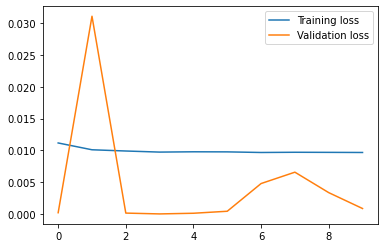

In [123]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [124]:
n_future=90

forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1T').tolist()

forecast = model.predict(trainX[-n_future:]) #forecast 

In [125]:
forecast_copies = np.repeat(forecast, dftraining.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i)

df_forecast = pd.DataFrame({'tmpDate':np.array(forecast_dates), 'BTCUSD_close':y_pred_future})
#df_forecast['tmpDate']=pd.to_datetime(df_forecast['tmpDate'])



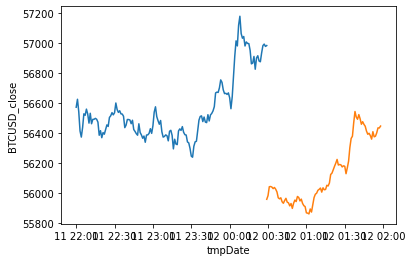

In [126]:
formatteddata['tmpDate'] = formatteddata.index
#original = formatteddata[['tmpDate', 'BTCUSD_close']]
original['tmpDate']=pd.to_datetime(original['tmpDate'])
original = original.loc[original['tmpDate'] >= '2021-5-11 10:00 PM']

sns.lineplot(original['tmpDate'], original['BTCUSD_close'])
sns.lineplot(df_forecast['tmpDate'], df_forecast['BTCUSD_close'])

In [127]:
df_forecast.head(90)

,tmpDate,BTCUSD_close
0,2021-05-12 00:29:00,55960.183594
1,2021-05-12 00:30:00,55984.679688
2,2021-05-12 00:31:00,56043.960938
3,2021-05-12 00:32:00,56045.414062
4,2021-05-12 00:33:00,56041.843750
...,...,...
85,2021-05-12 01:54:00,56380.765625
86,2021-05-12 01:55:00,56403.500000
87,2021-05-12 01:56:00,56436.621094
88,2021-05-12 01:57:00,56435.777344


In [38]:
print(trainX.shape[2])

15


In [39]:
trainX.shape[2]

15

In [103]:
history

In [105]:
model.evaluate(trainX, trainY)

22302/22302 [==============================] - 73s 3ms/step - loss: 0.0019


0.0019038395257666707

In [106]:
print(model.score(trainX, trainY))

AttributeError: 'Sequential' object has no attribute 'score'

In [107]:
model.predict(trainX)

array([[-0.76359653],
       [-0.76362336],
       [-0.763471  ],
       ...,
       [ 1.9262342 ],
       [ 1.9245949 ],
       [ 1.9258585 ]], dtype=float32)

In [108]:
forecast_copies

array([[1.9001443, 1.9001443, 1.9001443, ..., 1.9001443, 1.9001443,
        1.9001443],
       [1.9029372, 1.9029372, 1.9029372, ..., 1.9029372, 1.9029372,
        1.9029372],
       [1.9035945, 1.9035945, 1.9035945, ..., 1.9035945, 1.9035945,
        1.9035945],
       ...,
       [1.9262342, 1.9262342, 1.9262342, ..., 1.9262342, 1.9262342,
        1.9262342],
       [1.9245949, 1.9245949, 1.9245949, ..., 1.9245949, 1.9245949,
        1.9245949],
       [1.9258585, 1.9258585, 1.9258585, ..., 1.9258585, 1.9258585,
        1.9258585]], dtype=float32)

In [109]:
y_pred_future

array([54737.55 , 54787.125, 54798.793, 54808.254, 54816.95 , 54795.703,
       54820.68 , 54807.52 , 54798.96 , 54763.008, 54769.176, 54775.44 ,
       54752.816, 54740.965, 54757.844, 54764.01 , 54741.508, 54730.38 ,
       54705.855, 54751.406, 54691.95 , 54748.   , 54731.773, 54751.52 ,
       54754.855, 54747.74 , 54742.223, 54751.406, 54724.137, 54726.84 ,
       54707.42 , 54677.82 , 54676.7  , 54660.94 , 54714.867, 54660.52 ,
       54729.66 , 54731.277, 54770.293, 54759.137, 54790.746, 54786.59 ,
       54805.734, 54776.906, 54823.86 , 54791.246, 54821.277, 54822.582,
       54828.645, 54849.332, 54881.066, 54886.79 , 54911.613, 54909.35 ,
       54952.848, 54962.297, 54925.562, 54965.133, 54942.535, 54958.223,
       54949.125, 54942.098, 54901.254, 54946.633, 54954.094, 55053.45 ,
       54999.812, 55073.902, 55137.145, 55181.65 , 55168.5  , 55185.68 ,
       55206.035, 55198.812, 55190.15 , 55206.754, 55194.965, 55199.098,
       55137.3  , 55160.766, 55159.207, 55135.93 , 